## Introduction
The purpose of this notebook is to perform A/B testing on a simple dataset from the mobile game Cookie Cats, analyzing which version (`gate_30` or `gate_40`) yields better results.

A brief explanation of A/B testing: it is a statistical hypothesis testing method used to reveal the significance of differences in metric variable values between two groups, such as Group A and Group B.

Dataset Description:

- `userid`: a unique identifier representing each unique player

- `version`: indicates whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40)

- `sum_gamerounds`: the number of game rounds played by the player during the first week of installation

- `retention_1`: indicates whether the user came back to play the game 1 day after installation

- `retention_7`: indicates whether the user came back to play the game 7 days after installation

## Table of content
[0. Import packages & data](#0-import-packages--data)

[1. Exploratory Data Analysis](#1-exploratory-data-analysis)

* 1.1. Overview

* 1.2. Game rounds

* 1.3. Retention

* 1.4. Game rounds vs Retention

* 1.5. Summary

[2. A/B test](#2-ab-test)

* Hypothesis on game rounds
    
* Hypothesis on retention
    
[3. Conclusion](#conclusion)

## 0. Import packages & data 


In [1]:
# import base library
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# stats library for hypothesis testing
from scipy.stats import shapiro
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

# config warning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# load data
df = pd.read_csv('cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [3]:
df['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

## 1. Exploratory Data Analysis

- To understand data & process data if needed (missing values, outliners, etc.)
- Summarize data with stats and plots

### 1.1. Describe overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


### 1.2. Game rounds

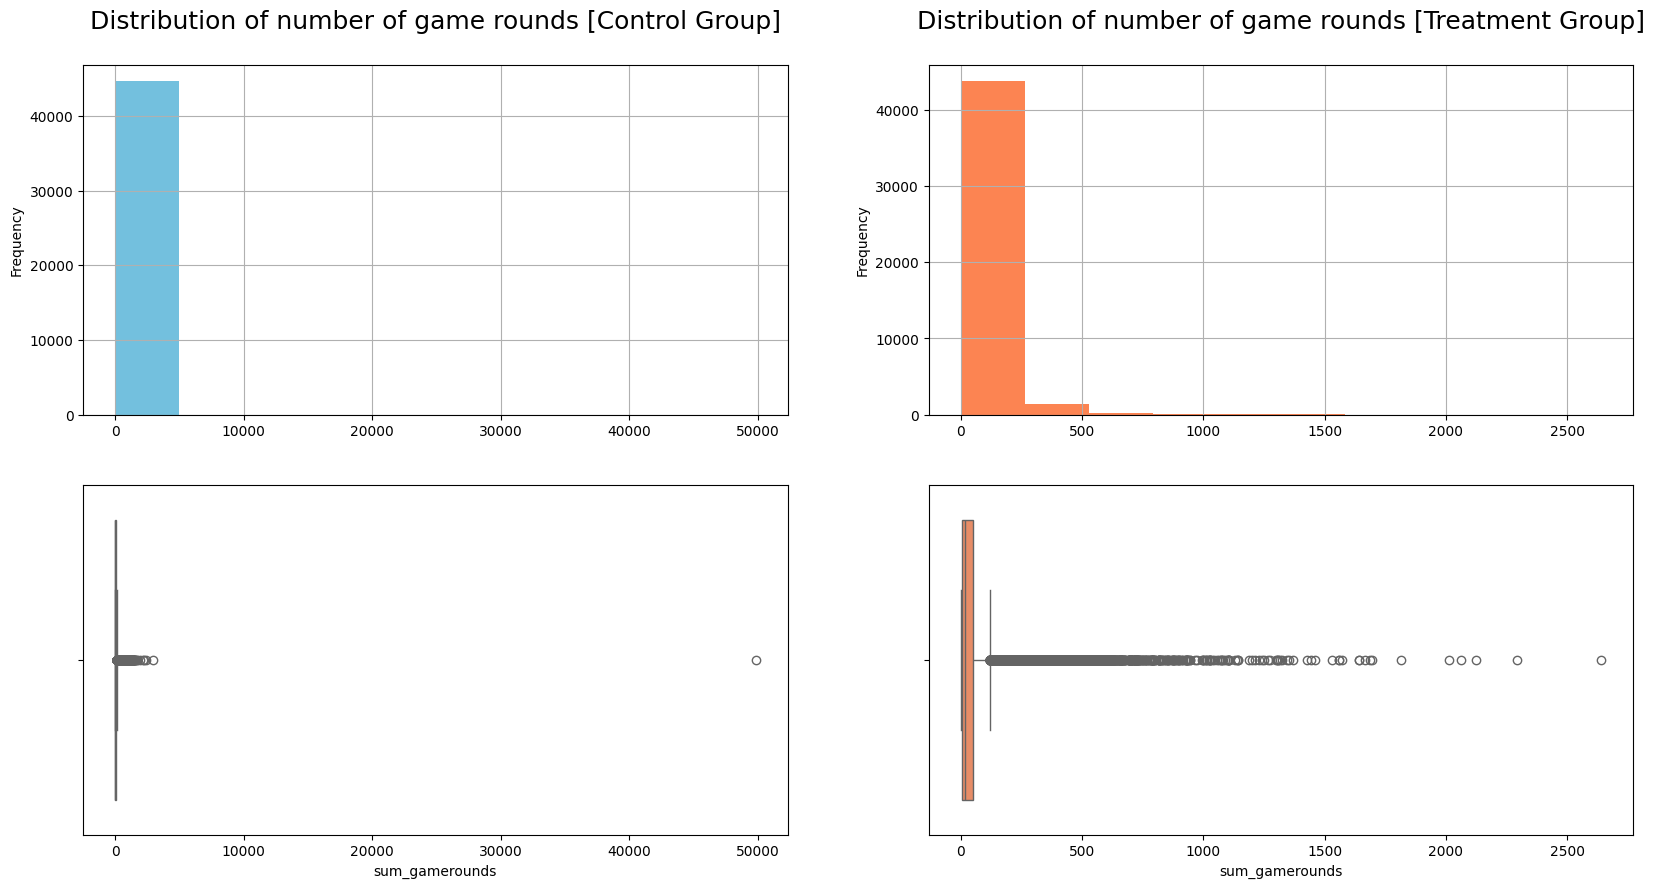

In [6]:
# plot distribution of game rounds using histogram & boxplot
fig, axes = plt.subplots(2, 2, figsize = (20,10))

# Control group
axes[0][0].set_title("Distribution of number of game rounds [Control Group]\n", fontsize = 18)
df[df.version=='gate_30']['sum_gamerounds'].hist(ax = axes[0][0], color = '#73C0DE')
axes[0][0].set_ylabel('Frequency')
sns.boxplot(x = df[df.version=='gate_30'].sum_gamerounds, ax = axes[1][0], color = '#73C0DE')

# Treatment group
axes[0][1].set_title("Distribution of number of game rounds [Treatment Group]\n", fontsize = 18)
df[~(df.version=='gate_30')]['sum_gamerounds'].hist(ax = axes[0][1], color = '#FC8452')
axes[0][1].set_ylabel('Frequency')
sns.boxplot(x = df[~(df.version=='gate_30')].sum_gamerounds, ax = axes[1][1], color = '#FC8452')

plt.show()

The Control group seems to have an extreme value that significantly scales up the range.

In [7]:
# find users with top number of game rounds
df.sort_values('sum_gamerounds', ascending=False).head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False


It would be abnormal for a person to finish about 50,000 rounds within a week, so that outlier will be dropped for the sake of obtaining qualified and normal data.

In [8]:
# remove extreme value - only the biggest one
df = df[df.sum_gamerounds < df.sum_gamerounds.max()].reset_index(drop=True)

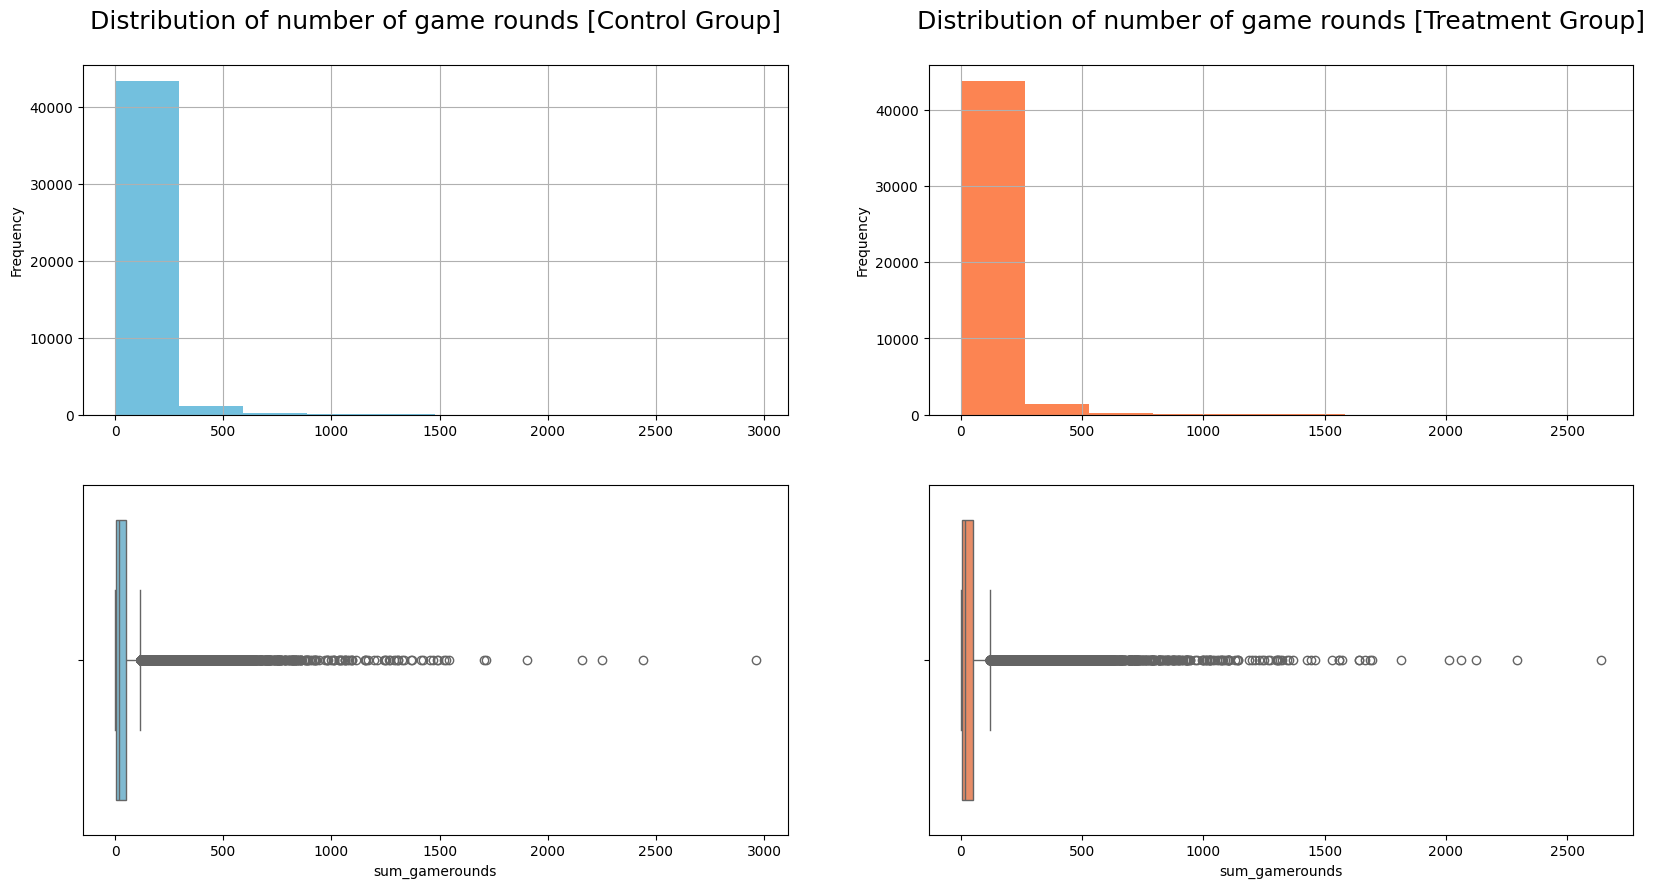

In [9]:
# plot distribution of game rounds using histogram & boxplot again
fig, axes = plt.subplots(2, 2, figsize = (20,10))
axes[0][0].set_title("Distribution of number of game rounds [Control Group]\n", fontsize = 18)
df[df.version=='gate_30']['sum_gamerounds'].hist(ax = axes[0][0], color = '#73C0DE')
axes[0][0].set_ylabel('Frequency')
sns.boxplot(x = df[df.version=='gate_30'].sum_gamerounds, ax = axes[1][0], color = '#73C0DE')
axes[0][1].set_title("Distribution of number of game rounds [Treatment Group]\n", fontsize = 18)
df[~(df.version=='gate_30')]['sum_gamerounds'].hist(ax = axes[0][1], color = '#FC8452')
axes[0][1].set_ylabel('Frequency')
sns.boxplot(x = df[~(df.version=='gate_30')].sum_gamerounds, ax = axes[1][1], color = '#FC8452')
plt.show()

It can be seen that after removing the extreme value, the distribution of game rounds of 2 groups are now similar and likely **skewed**.

In [10]:
# total game rounds & avg rounds per user of each group
total_gamerounds = df.groupby('version').agg(
    total_gamerounds=pd.NamedAgg(column='sum_gamerounds', aggfunc='sum'),
    total_users=pd.NamedAgg(column='userid', aggfunc='count'),
).reset_index()
total_gamerounds['avg_gamerounds_per_user'] = total_gamerounds['total_gamerounds']/total_gamerounds['total_users']
total_gamerounds

,version,total_gamerounds,total_users,avg_gamerounds_per_user
0,gate_30,2294941,44699,51.342111
1,gate_40,2333530,45489,51.298776


The number of game rounds per user on average between the two groups is roughly the same, around 51 rounds.

### 1.3. Retention (Day 1 & Day 7)

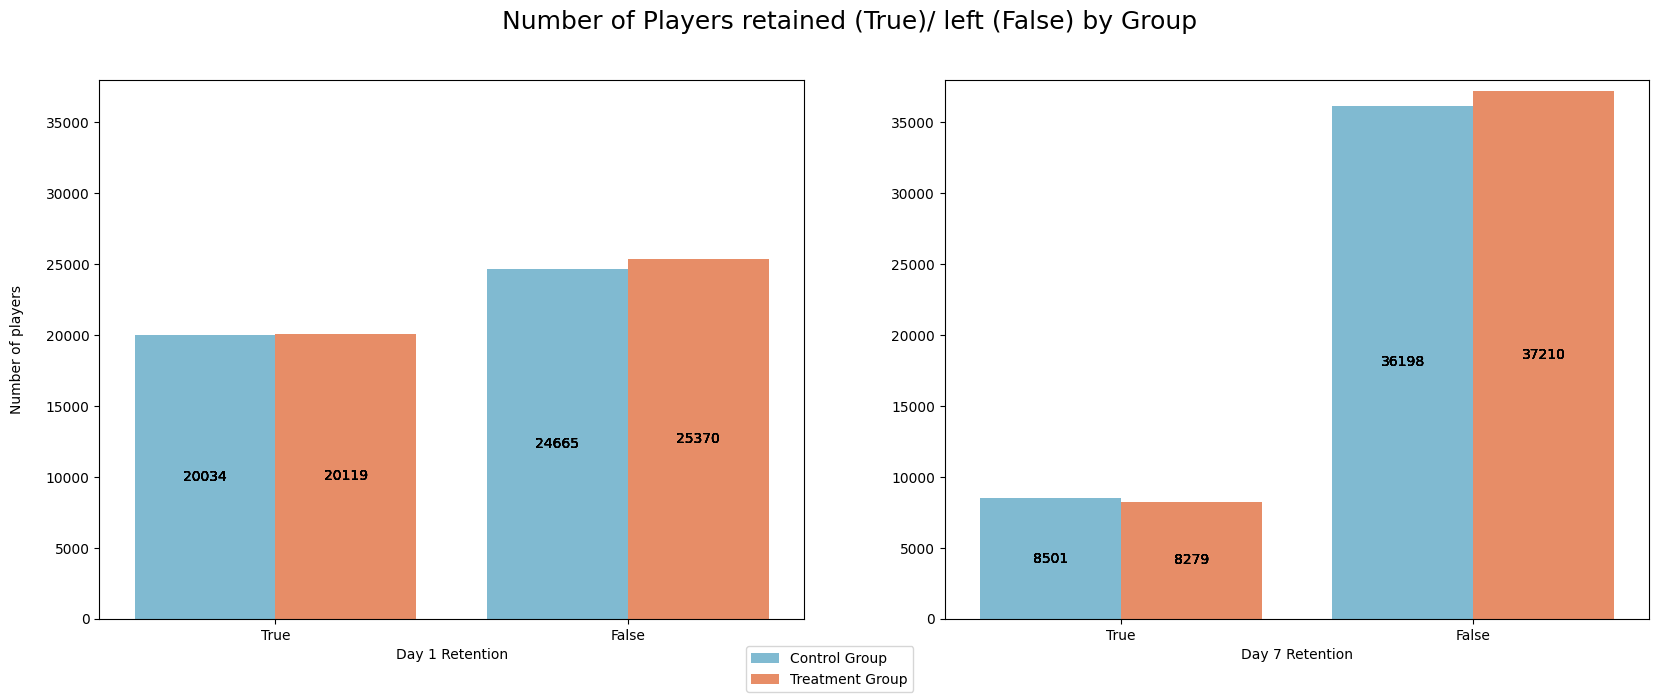

In [11]:
# count number of players after Day 1 and Day 7
fig, axes = plt.subplots(1, 2, figsize = (20, 7))
plt.suptitle("Number of Players retained (True)/ left (False) by Group", fontsize = 18)
sns.countplot(x = "retention_1", data = df, hue = "version",
              ax = axes[0], palette = ["#73C0DE", "#FC8452"], order=['True', 'False'])\
              .set(xlabel = 'Day 1 Retention', ylabel='Number of players\n')
sns.countplot(x = "retention_7", data = df, hue = "version",
              ax = axes[1], palette = ["#73C0DE", "#FC8452"], order=['True', 'False'])\
              .set(xlabel = 'Day 7 Retention', ylabel='')

for ax in axes:
    ax.get_legend().remove()
    for p in ax.patches:
        ax.bar_label(ax.containers[0], label_type='center')
        ax.bar_label(ax.containers[1], label_type='center')
        ax.set_ylim(0, 38000)
        
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Control Group', 'Treatment Group'], loc = "lower center")

plt.show()

Overall, approximately half of users stop playing the game after Day 1 of installation, while about 4/5 users quit after Day 7.

The number of players who retained after Day 1 is approximately the same among the two versions (note here: Treatment Group `gate_40` has more users than Control Group; therefore, the orange bars should exceed the blue bars by a little bit). Regarding Day 7, the number of retained users in the Control Group is slightly higher.

This pattern will also be validated with hypothesis testing in section 2.

In [12]:
# mean retention rate of each group
retention_rates = df.groupby('version').agg(
    retention_1_rate=pd.NamedAgg(column='retention_1', aggfunc='mean'),
    retention_7_rate=pd.NamedAgg(column='retention_7', aggfunc='mean')
).reset_index()
retention_rates

,version,retention_1_rate,retention_7_rate
0,gate_30,0.448198,0.190183
1,gate_40,0.442283,0.182000


Retention rates for Control Group `gate_30` are slightly higher than those for Treatment Group `gate_40` version on both Day 1 and Day 7.

### 1.4. Game rounds vs Retention

In [13]:
# exclude users who left after day 1 to analyze day 7 retention
df7 = df[df.retention_1]

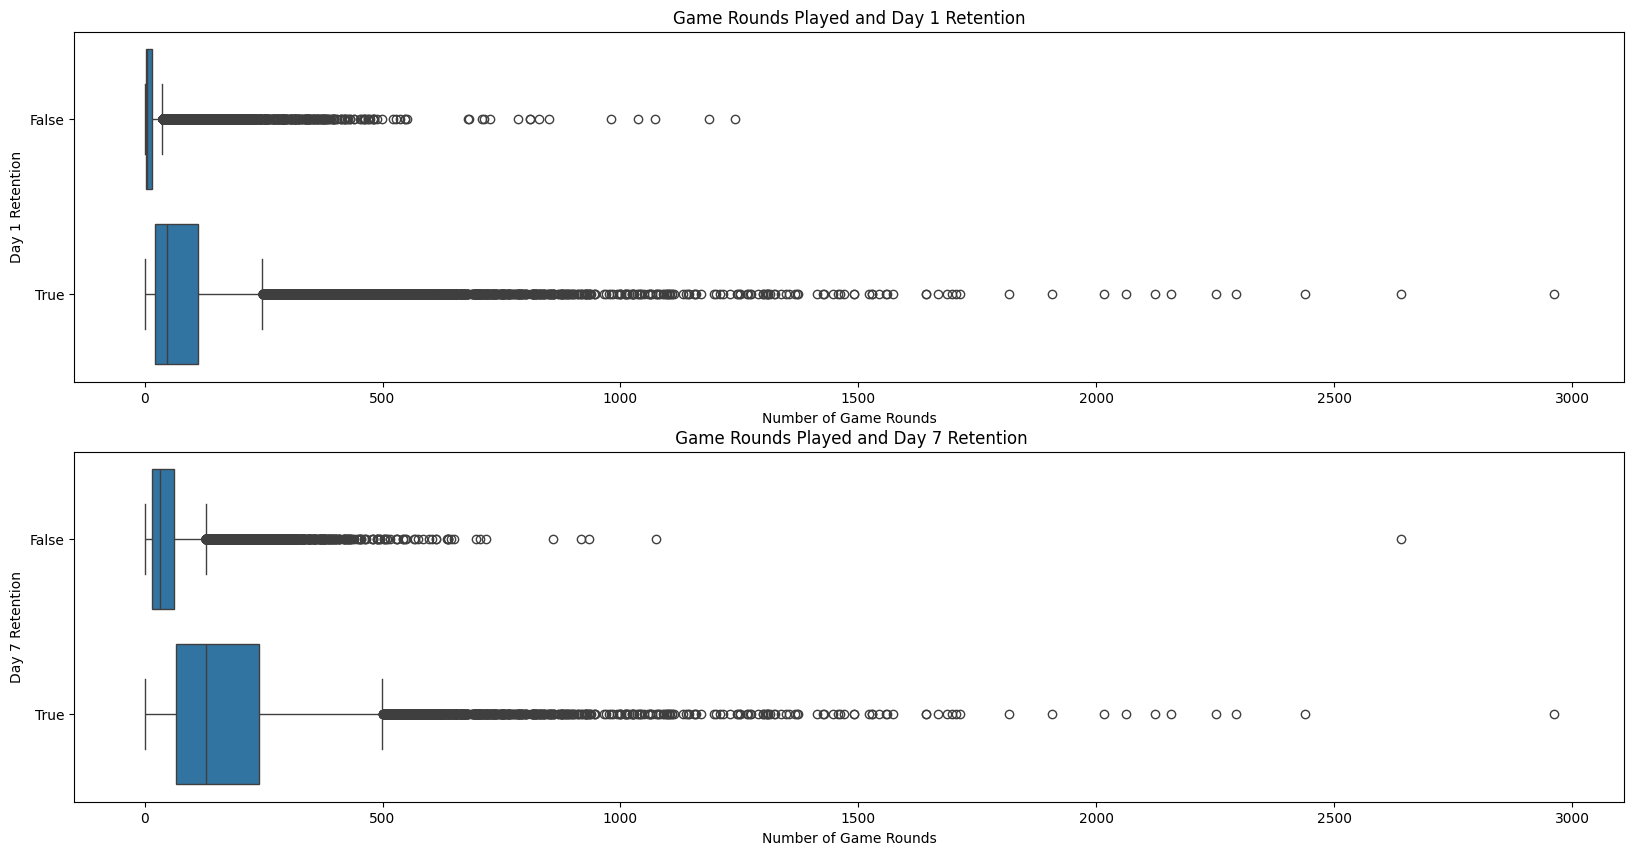

In [14]:
# distribution of game rounds by retention on day 1 & day 7
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

sns.boxplot(y='retention_1', x='sum_gamerounds', data=df, ax=axes[0], orient='h')
axes[0].set(title = 'Game Rounds Played and Day 1 Retention',
            ylabel = 'Day 1 Retention', xlabel = 'Number of Game Rounds')

sns.boxplot(y='retention_7', x='sum_gamerounds', data=df7, ax=axes[1], orient='h')
axes[1].set(title = '\n Game Rounds Played and Day 7 Retention',
            ylabel = 'Day 7 Retention', xlabel = 'Number of Game Rounds')

plt.show()

Let's zoom to the quantiles (limiting to whisker range) for easier comparison.

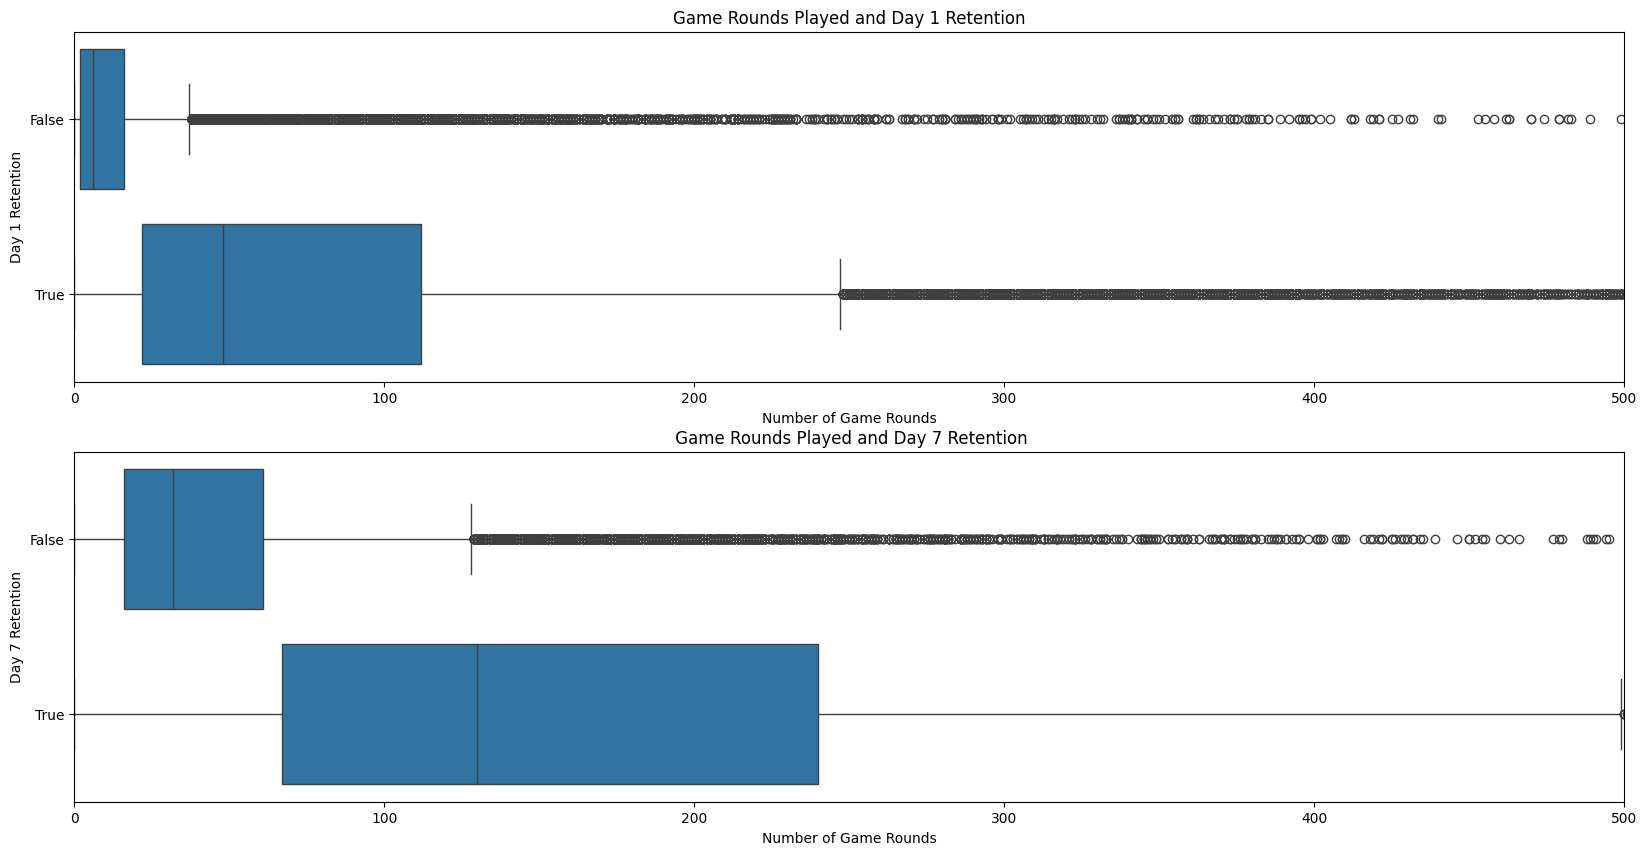

In [15]:
axes[0].set_xlim(0, 500)
axes[1].set_xlim(0, 500)
fig

In [16]:
df[df['retention_1']].describe()[["sum_gamerounds"]].T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,40153.0,94.897467,136.472092,0.0,22.0,48.0,112.0,2961.0


In [17]:
df7[df7['retention_7']].describe()[["sum_gamerounds"]].T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,13182.0,187.043089,191.926715,0.0,67.0,130.0,240.0,2961.0


Players who retained after Day 1 and Day 7 tend to have played more game rounds than those who did not retain. This results in a higher median and a wider range of the interquartile for the group of retained players.

Users who retained made significant progress from Day 1 to Day 7, with the interquartile range ranging from (22, 112) to (67, 240).

#### Which levels do users tend to stop playing after Day 1?

In [18]:
df1_left = df[~df.retention_1]

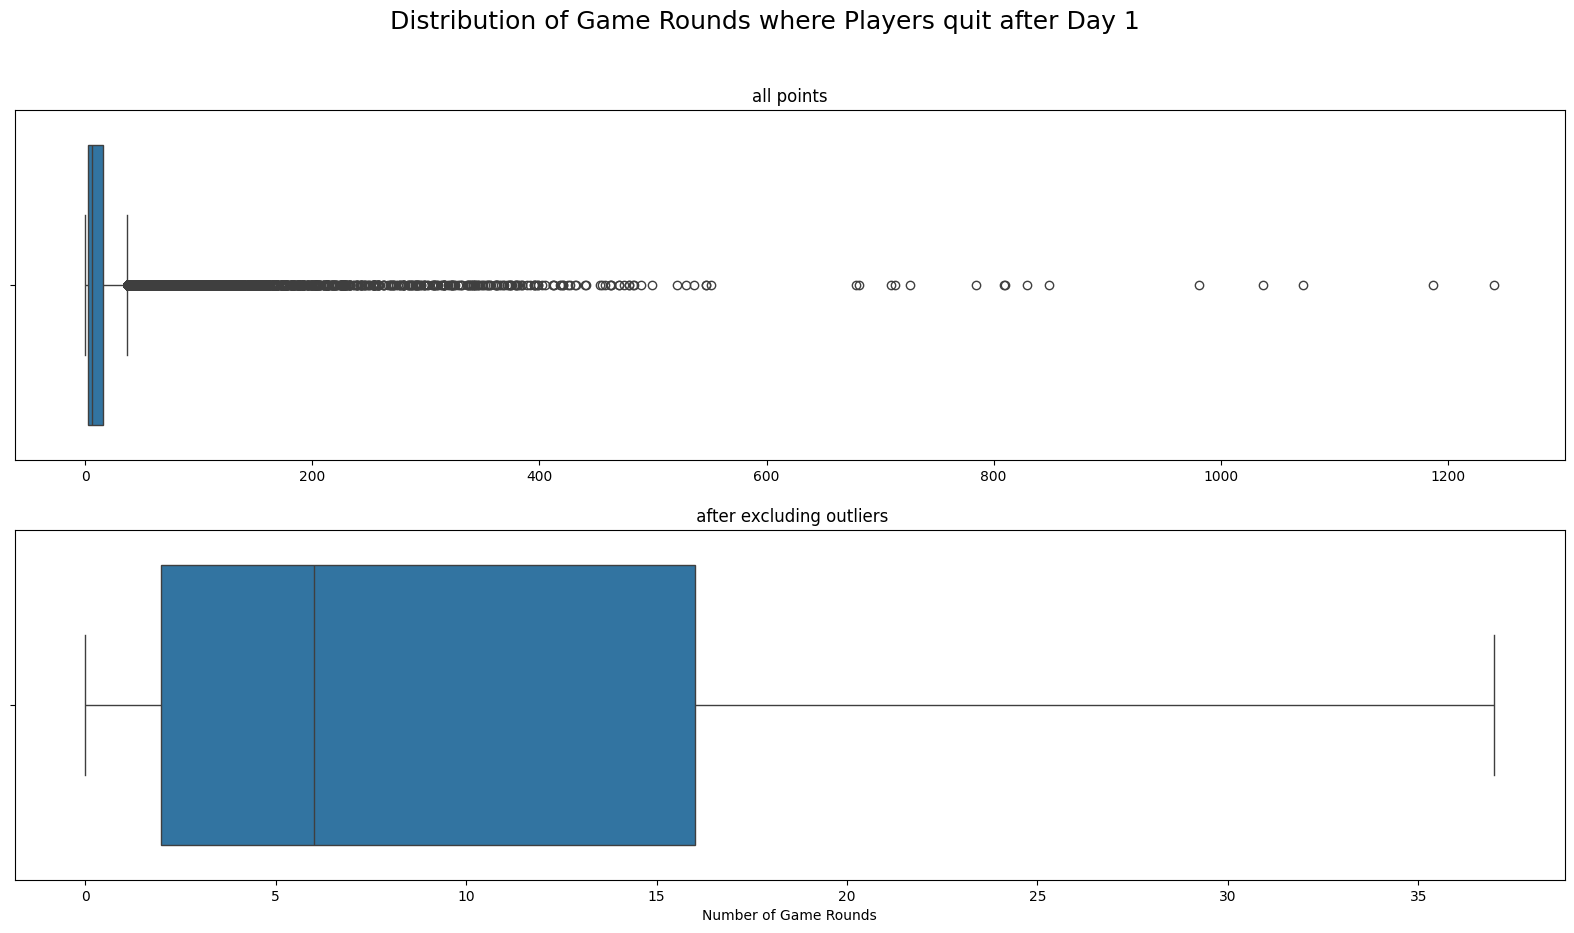

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

plt.suptitle("Distribution of Game Rounds where Players quit after Day 1", fontsize = 18)

sns.boxplot(x='sum_gamerounds', data=df1_left, orient='h', ax=axes[0])
axes[0].set(title ='all points', xlabel = '')

sns.boxplot(x='sum_gamerounds', data=df1_left, orient='h', showfliers=False, ax=axes[1])
axes[1].set(title = '\n after excluding outliers', xlabel = 'Number of Game Rounds')

plt.show()

After removing outliners, it can be seen that users who quit after one day tend to stop at level between 2 and 16.

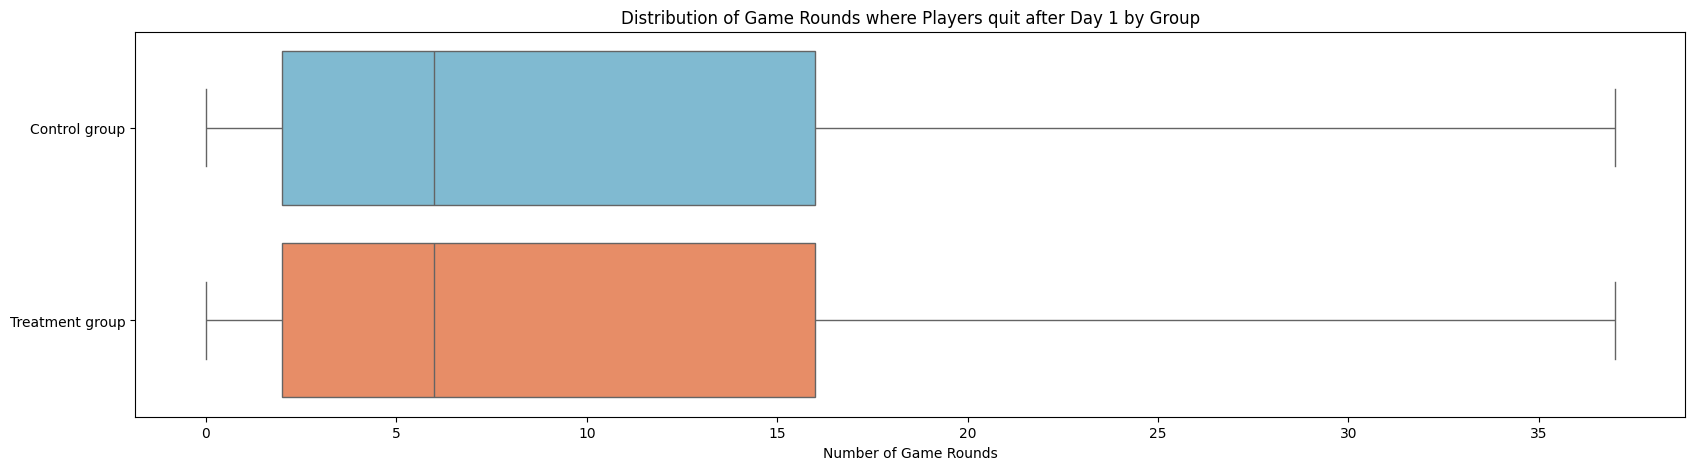

In [20]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(y='version', x='sum_gamerounds', data=df1_left, orient='h', showfliers=False, 
            hue='version', palette= ["#73C0DE", "#FC8452"])
ax.set(title='Distribution of Game Rounds where Players quit after Day 1 by Group', 
       xlabel = 'Number of Game Rounds', ylabel='')
ax.set_yticklabels(['Control group', 'Treatment group'])
plt.show()

The range of quit rounds after 1 day of installation is not different between the two groups.

#### Which levels do users tend to stop playing after Day 7?

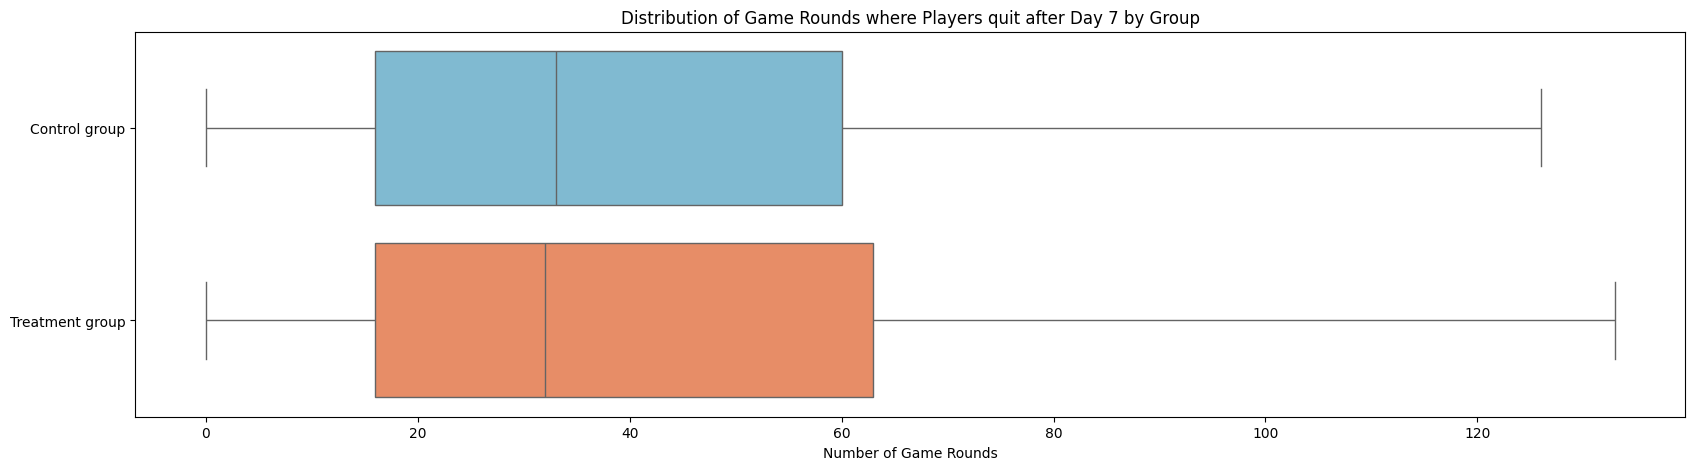

In [21]:
df7_left = df7[~df7.retention_7]

fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(y='version', x='sum_gamerounds', data=df7_left, orient='h', showfliers=False, 
            hue='version', palette= ["#73C0DE", "#FC8452"])
ax.set(title='Distribution of Game Rounds where Players quit after Day 7 by Group', 
       xlabel = 'Number of Game Rounds', ylabel='')
ax.set_yticklabels(['Control group', 'Treatment group'])
plt.show()

There's a slight difference in the range of quit rounds between the two groups, with the Treatment group seeming to play more rounds compared to the Control group.

#### There are many players who haven't played any rounds.
As observed in the statistics, the minimum value of the number of game rounds is 0. Let's count how many users didn't play at all.

In [22]:
len(df[df.sum_gamerounds == 0]), df[df.sum_gamerounds == 0]['retention_7'].value_counts(), df[df.sum_gamerounds == 0]['retention_1'].value_counts()

(3994,
 retention_7
 False    3965
 True       29
 Name: count, dtype: int64,
 retention_1
 False    3907
 True       87
 Name: count, dtype: int64)

Out of 3994 players, who didn't interact with the game and thus couldn't see how the level of the gate would affect their experience, will be removed from the A/B test analysis.

In [23]:
# final dataset for a/b test
df = df[df.sum_gamerounds>0].reset_index(drop=True)

### 1.5. Summary

- The distribution of game rounds is right-skewed regardless of the group.

- The retention rate of the Control Group (`gate_30`) is slightly higher compared to the Treatment Group (`gate_40`).

- While there's limited data to analyze user churn, it can be observed that users tend to quit after day 1 within the level range of (2, 16), and after day 7 within the level range of (18, 60).


## 2. A/B test 

Test hypotheses and check assumptions based on data characteristics. The table below summarizes simplified options of statistical tests for each data type.

![title](statistical_test.png)

For this case, I perform three hypothesis tests with a 0.05 level of significance.

First, for `sum_gamerounds` (a numerical variable), the steps include checking normality, then homogeneity of variances (if normality is met), and finally applying the appropriate test (*t-test* or *Mann-Whitney U test*).

For the categorical variables `retention_1` and `retention_7`, to compare the retention success (True) between the two groups (unpaired samples), I will apply the *two-sample Z test for proportions* and the *chi-square test*.

In [24]:
# split control & treatment group
df_control = df[df.version=='gate_30'].reset_index(drop=True)
df_treatment = df[~(df.version=='gate_30')].reset_index(drop=True)

### 2.1. Hypothesis on Total Number of Game Rounds
Hypothesis: Is there a statistically significant difference between the total number of rounds played (`sum_gamerounds`) of the two groups (Control Group - `gate_30` and Treatment Group - `gate_40`)?

- Null Hypothesis (H0): There is no statistically significant difference between the total number of rounds played for the two versions of players.

- Alternative Hypothesis (H1): There is a statistically significant difference between the total number of rounds played for the two versions of players.


In [25]:
# extract distributions for sum_gamerounds
gamerounds_control = df_control["sum_gamerounds"]
gamerounds_treatment = df_treatment["sum_gamerounds"]

In [26]:
# set level of significance
alpha = 0.05

#### Combine all steps described above into one function:

*note: For simplified testing, the function only covers the Shapiro-Wilk Test for checking normality. There are also other methods like the Kolmogorov-Smirnov Test or Q-Q plot.*


In [27]:
# %%writefile AB_test_functions.py
# A/B Testing Function for Numerical data
def AB_Test_Numerical(df_control, df_treatment, target, alpha=0.05):
    '''
    Normality test: Shaphiro Wilk Test
    Homogeneity test: Levene's Test
    Hypothesis test: t-test or Mann-Whiteney U Test
    *applying for continuous variables*

    Parameters:
    -----------
    df_control: pd.DataFrame
        Dataframe of control group
    df_treatment: pd.DataFrame
        Dataframe of treatment group - apply new change(s)
    target: str
        Column name of df - target variable of the test
    alpha: float (0.05 by default)
        Level of significance (common <= alpha)

    Returns:
    -----------
    Testing results including reject or not reject null hypothesis
    '''
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats

    ### Split A/B
    groupA = df_control[target]
    groupB = df_treatment[target]
    
    ### Testing the Normality Assumption
    print("### Testing the Normality Assumption for "+target+" ###\n")
    p_shapiro_A = shapiro(groupA)[1]
    p_shapiro_B = shapiro(groupB)[1]
    # H0: Distribution is Normal
    # H1: Distribution is not Normal
    
    if (p_shapiro_A>alpha) & (p_shapiro_B>alpha):
        print(f"Shaphiro Wilk Test resulted in p > {alpha} for both GroupA and GroupB,\n which indicates that H0 cannot be rejected. Thus GroupA and GroupB are likely to normal distribution.\n")
        
        # Parametric Test
        print("\n###Testing the Homogeneity Assumption for "+target+" ###\n")
        # Assumption: Homogeneity of variances
        p_levene = stats.levene(groupA, groupB)[1]
        # H0: Homogeneity
        # H1: Heterogeneous
        
        if p_levene > alpha:
            # Homogeneity
            print(f"\nLevene's Test for Homogeneity resulted in p = {p_levene} > {alpha}, which indicates that H0 cannot be rejected.\n")
            print(" Thus, variances of GroupA and GroupB are equal.","\n")

            print("\n### Testing Hypothesis for "+target+" with t-test & equal variances###")
            p_ttest = stats.p_ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 
            # H1: M1 != M2
        else:
            # Heterogeneous
            print(f"Levene's Test for Homogeneity resulted in p = {p_levene} < {alpha}, which indicates that H0 is rejected.")
            print("Thus, variances of GroupA and GroupB are equal.")

            print("\n### Testing Hypothesis for "+target+" with t-test & unequal variances###\n")
            p_ttest = stats.p_ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2
            # H1: M1 != M2
    else:
        print(f"Shaphiro Wilk Test resulted in p < {alpha} for one or both GroupA and GroupB, which indicates that H0 is rejected.\nThus GroupA and GroupB are not likely to normal distribution.\n")
        # Non-Parametric Test
        print("\n### Testing Hypothesis for "+target+" with Mann-Whiteney U Test ###\n")
        p_ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 
        # H1: M1 != M2 
    
    if p_ttest < alpha:
        print(f'Hypothesis test result in p = {p_ttest:.3f} < {alpha}, which indicates that H0 is rejected.\nThus, mean of {target} between GroupA & Group B are not similar.')
    else:
        print(f'Hypothesis test result in p = {p_ttest:.3f} > {alpha}, which indicates that H0 cannot be rejected.\nThus, mean of {target} between GroupA & Group B are not likely unsimilar.')


#### Apply test

In [28]:
from AB_test_functions import AB_Test_Numerical

In [29]:
AB_Test_Numerical(df_control, df_treatment, 'sum_gamerounds')

### Testing the Normality Assumption for sum_gamerounds ###

Shaphiro Wilk Test resulted in p < 0.05 for one or both GroupA and GroupB, which indicates that H0 is rejected.
Thus GroupA and GroupB are not likely to normal distribution.


### Testing Hypothesis for sum_gamerounds with Mann-Whiteney U Test ###

Hypothesis test result in p = 0.118 > 0.05, which indicates that H0 cannot be rejected.
Thus, mean of sum_gamerounds between GroupA & Group B are not likely unsimilar.


As it can be seen from the result of the Mann-Whitney U Test, there is no significant evidence to reject the null hypothesis. We can thus conclude that the version plays no role in affecting the values of sum_gamerounds. 

### 2.2. Hypothesis on Retention
Hypothesis: Is the proportion of users who retained (`retention_1`/`retention_7`) different between the Control Group (`gate_30`) and the Treatment Group (`gate_40`)?

- Null Hypothesis (H0): There is no difference in the proportions of the outcome (retain or not retain) between the Control Group and the Treatment Group.

- Alternative Hypothesis (H1): There is a difference in the proportions of the outcome between the Control Group and the Treatment Group.


#### Combine all steps described above into one function:

In [30]:
# %%writefile -a AB_test_functions.py

# A/B Testing Function for Categorical data (binary)
def AB_Test_Categorical(df_control, df_treatment, target, condition, ztest_proportions = True, chisquare_test = True, alpha=0.05):
    '''
    Hypothesis test: two-sample Z Test for proportions and/or Chi-square Test
    *applying for binary categorical variables (2-dimension), thus will be treated as success or not*

    Parameters:
    -----------
    df_control: pd.DataFrame
        Dataframe of control group
    df_treatment: pd.DataFrame
        Dataframe of treatment group - apply new change(s)
    target: str
        Column name of df - target variable of the test
    condition: str/ bool
        condition of the target to consider as a success
    ztest_proportions: bool
        whether to performe this test
    chisquare_test: bool
        whether to performe this test
    alpha: float (0.05 by default)
        Level of significance (common <= alpha)

    Returns:
    -----------
    Testing results including reject or not reject null hypothesis
    '''
    import numpy as np
    
    # calculate all observations & frequencies
    nobs_groupA, nobs_groupB = len(df_control[target]), len(df_treatment[target])
    successes_groupA = len(df_control[df_control[target]==condition])
    successes_groupB = len(df_treatment[df_treatment[target]==condition])

    if ztest_proportions:

        from statsmodels.stats.proportion import proportions_ztest

        print("\n### Testing Hypothesis for "+target+" with two-sample Z Test for proportions ###\n")
        count = np.array([successes_groupA, successes_groupB])
        nobs = np.array([nobs_groupA, nobs_groupB])
        p_prop_ztest = proportions_ztest(count=count, nobs=nobs)[1]
        if p_prop_ztest > alpha:
            print(f"Hypothesis test result in p = {p_prop_ztest:.3f} > {alpha}, which indicates that H0 cannot be rejected.\nThus, the two proportions might be the same.\n")
        else:
            print(f"Hypothesis test result in p = {p_prop_ztest:.3f} < {alpha}, which indicates that H0 is rejected.\n Thus, the two proportions might be different.\n")
        
    if chisquare_test:

        import scipy.stats as stats

        print("\n### Testing Hypothesis for "+target+" with Chi-square Test ###\n")
        rxc_table = np.array([[successes_groupA, nobs_groupA - successes_groupA],
                              [successes_groupB, nobs_groupB - successes_groupB]])
        p_chi2 = stats.chi2_contingency(observed=rxc_table)[1]
        if p_chi2 > alpha:
            print(f"Hypothesis test result in p = {p_chi2:.3f} > {alpha}, which indicates that H0 cannot be rejected.\nThus, the two proportions might be the same.\n")
        else:
            print(f"Hypothesis test result in p = {p_chi2:.3f} < {alpha}, which indicates that H0 is rejected.\n Thus, the two proportions might be different.\n")

#### Apply test

In [31]:
from AB_test_functions import AB_Test_Categorical

- `retention_1`

In [32]:
AB_Test_Categorical(df_control, df_treatment, 'retention_1', True)


### Testing Hypothesis for retention_1 with two-sample Z Test for proportions ###

Hypothesis test result in p = 0.114 > 0.05, which indicates that H0 cannot be rejected.
Thus, the two proportions might be the same.


### Testing Hypothesis for retention_1 with Chi-square Test ###

Hypothesis test result in p = 0.116 > 0.05, which indicates that H0 cannot be rejected.
Thus, the two proportions might be the same.



- `retention_7`

In [33]:
AB_Test_Categorical(df_control, df_treatment, 'retention_7', True)


### Testing Hypothesis for retention_7 with two-sample Z Test for proportions ###

Hypothesis test result in p = 0.003 < 0.05, which indicates that H0 is rejected.
 Thus, the two proportions might be different.


### Testing Hypothesis for retention_7 with Chi-square Test ###

Hypothesis test result in p = 0.003 < 0.05, which indicates that H0 is rejected.
 Thus, the two proportions might be different.



The results of the two tests are consistent. The null hypothesis for `retention_1` is not rejected, indicating no significant difference in retention rates between the groups after 1 day. 

Meanwhile, the null hypothesis for `retention_7` is rejected, indicating a significant difference in the proportion of players who are still retained 7 days after installation.


## Conclusion

Based on the results of the A/B testing, it can be observed that there is an insignificant difference in both `sum_gamerounds` and `retention_1` between the two versions.

The hypothesis regarding `retention_1` might be understandable given one of the findings spotted from EDA in Section 1, which is 75% of players' game rounds after Day 1 range from 2 to 16, some don't even start the game or only engage in a few rounds. Consequently, drawing any conclusions after Day 1 may be challenging, as most players do not progress to level 30 and may not be influenced by the version type.

However, a significant difference in retention_7 was observed between the two versions, suggesting that the retention rate after a week of installation is higher for `gate_30` compared to `gate_40`.

Therefore, the company should consider adopting `gate_30` over `gate_40`. Additionally, it may be beneficial for the company to create some incentive bonuses to encourage users to make progress in the first 20 rounds, as players are more likely to quit during these levels and cannot let the `gate` do it work.